In [1]:
#  NAVD and NGVD, NGVD is approximately 2.73 feet higher at this location.

# unit conversions: https://pubs.usgs.gov/sir/2010/5040/section.html
# NAVD88 gage height in feet, multiply by 0.3048 to get meter


In [1]:
# import matplotlib
# import matplotlib.pyplot as plt
# # from climata.usgs import DailyValueIO
# import pandas as pd
# from pandas.plotting import register_matplotlib_converters
# import numpy as np

# register_matplotlib_converters()
# plt.style.use('ggplot')

# import sys
# sys.path.append('/Users/octaviacrompton/Google_Drive_quatratavia/estuaries_jenner/scripts/')
# sys.path.append("drive/MyDrive/estuaries_Jenner/scripts/")


In [2]:
import seaborn as sns
import pandas as pd
import matplotlib.pylab as plt

# std libs
from pathlib import Path
import sys, importlib

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use("ggplot")
mpl.rcParams.update({"figure.dpi": 300, "figure.figsize": (12, 6)})

# paths: root = this file/notebook folder
try:
    here = Path(__file__).resolve().parent   # .py files
except NameError:
    here = Path.cwd().resolve()              # notebooks

root    = here.parent                                
scripts = root / "scripts"
if str(scripts) not in sys.path:
    sys.path.insert(0, str(scripts))          # ensure your modules are found first

# dev-friendly reload while keeping import *
def _reload_star(mod_names):
    importlib.invalidate_caches()
    for name in mod_names:
        if name in sys.modules:
            del sys.modules[name]

_mods = ["plot_config", "timeseries_functions", "seepage_analysis", "seepage_plots"]
_reload_star(_mods)

# keep star-imports as requested
from plot_config import *
from timeseries_functions import *
from seepage_analysis import *
from seepage_plots import *

data_path = root / "data"

hypso = pd.read_excel(data_path / "RR_stage_storage.xlsx", header=3)


In [3]:
# plt.rcParams['figure.figsize'] = (12.0, 6.0)
# for mod in ['plot_config', 'timeseries_functions', 'seepage_analysis', 'seepage_plots']:
#     if mod in sys.modules:
#         del sys.modules[mod]

# import plot_config
# from timeseries_functions import *
# from seepage_analysis import *
# from seepage_plots import *
# import matplotlib as mpl
# mpl.rcParams['figure.dpi'] = 300

In [4]:
# Start with the usual.
import hydrofunctions as hf
%matplotlib inline
hf.__version__
mpl.rcParams['figure.dpi'] = 300

## Get USGS gauge data

In [5]:

site_Hacienda = hf.NWIS(
    '11467000', 'iv', start_date='2000-04-26', parameterCd='00060'    
)

Hacienda = site_Hacienda.df('data').rename(
    columns={'USGS:11467000:00060:00000': 'Q_Hacienda'}, inplace=False
)

Hacienda = Hacienda.loc[Hacienda.index.round('15min')]

Hacienda.to_parquet(data_path / "interim" / "Hacienda.parquet")

Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=11467000&parameterCd=00060&startDT=2000-04-26


In [6]:
# %%time
# site_Hacienda = hf.NWIS( '11467000',  'iv', start_date='2000-04-26',  parameterCd = '00060', 
#                         file= data_path / "Hacienda.parquet")

# Hacienda = site_Hacienda.df('data').rename(
#     columns = {'USGS:11467000:00060:00000':'Q_Hacienda',
#               }, inplace = False)

# Hacienda = Hacienda.loc[Hacienda.index.round('15min')]



In [7]:
# site_Hacienda_dv = hf.NWIS( '11467000',  'dv', start_date='2000-04-26', file='Hacienda_dv.parquet')
# [c  for c in site_Hacienda_dv.df('data').columns if '80154'  in c or '00060' in c ]

# Hacienda_dv = site_Hacienda_dv.df('data').rename(
#     columns = {'USGS:11467000:00060:00003':'Q',
#                'USGS:11467000:80154:00003' : 'SSC',
#               },
#     inplace = False)


# cols = [col for col in Hacienda_dv.columns if '63680' in col]

# Hacienda_dv['Turbidity'] = np.nanmedian(Hacienda_dv[cols],1)

In [8]:
site_Austin = hf.NWIS(
    '11467200', 'iv', start_date='2000-04-26', parameterCd='00060'   
)

Austin = site_Austin.df('data').rename(
    columns={'USGS:11467200:00060:00000': 'Q_Austin'},
    inplace=False
)

Austin = Austin.loc[Austin.index.round('15min')]
Austin.to_parquet(data_path / "interim" / "Austin.parquet")

Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=11467200&parameterCd=00060&startDT=2000-04-26


In [9]:
overlap = list(set(Hacienda.index) & set( Austin.index))

Hacienda.loc[overlap, 'Q_Austin'] = Austin.loc[overlap].Q_Austin
Hacienda.loc[Hacienda['Q_Austin'].isna(), 'Q_Austin'] = 0

Hacienda['Q'] = Hacienda['Q_Austin'] +  Hacienda['Q_Hacienda']


In [10]:
# Hacienda[['Q_Austin', 'Q_Hacienda', 'Q']].tail(20000)[:10000].plot()

In [11]:
len(Hacienda.query("Q > 0")),len(Hacienda.query("Q_Hacienda > 0"))

(879631, 879631)

In [12]:
site_Jenner = hf.NWIS(
    '11467270', 'iv', start_date='2018-01-01', parameterCd='00065'    
)

Jenner = site_Jenner.df('stage').rename(columns={'USGS:11467270:00065-229225:00000':'USGS_h'
                                                }, inplace=False)[['USGS_h']]

Jenner.to_parquet(data_path / "interim" / "Jenner.parquet")

Requested data from https://nwis.waterservices.usgs.gov/nwis/iv/?format=json%2C1.1&sites=11467270&parameterCd=00065&startDT=2018-01-01


In [13]:
# site_Jenner = hf.NWIS( '11467270',  'iv', start_date='2018-04-26', parameterCd = '00065') #, file='parquets/Jenner.parquet')
# site_Jenner

In [14]:
# d = site_Jenner.df('stage').rename(columns={'USGS:11467270:00065-229225:00000':'USGS_h',
#                                         'USGS:11467270:00065-241826:00000':'USGS_h_NGVD'
#                                                 }, inplace=False)[['USGS_h', 'USGS_h_NGVD']]

# Read visitor center data

In [15]:

# unit conversions: https://pubs.usgs.gov/sir/2010/5040/section.html
# NAVD88 gage height in feet, multiply by 0.3048 to get meter
# 2.74 - 0.3048*2.74

In [16]:
# root = '/Users/octaviacrompton/Google_Drive_quatratavia/estuaries_jenner/'

# root = '/Users/octavia/Google_Drive_quatratavia/estuaries_jenner/'

In [25]:
# #  Jenner visitor center data
# Jenner2011 = pd.read_csv('{0}/data/visitor_center/Jenner_River_Gauge_2011.csv'.format(root))

# Jenner2012 = pd.read_csv('{0}/data/visitor_center/Jenner_River_Gauge_2012.csv'.format(root))
# Jenner2013 = pd.read_csv('{0}/data/visitor_center/Jenner_River_Gauge_2013.csv'.format(root))

# Jenner2014 = pd.read_csv('{0}/data/visitor_center/Jenner_River_Gauge_2014.csv'.format(root))
# Jenner2015 = pd.read_csv('{0}/data/visitor_center/Jenner_River_Gauge_2015.csv'.format(root))

# Jenner2016 = pd.read_csv('{0}/data/visitor_center/Jenner_River_Gauge_2016.csv'.format(root))
# Jenner2017 = pd.read_csv('{0}/data/visitor_center/Jenner_River_Gauge_2017.csv'.format(root))


# Jenner2018 = pd.read_csv('{0}/data/visitor_center/Jenner_River_Gauge_2018.csv'.format(root))
# Jenner2019 = pd.read_csv('{0}/data/visitor_center/Jenner_River_Gauge_2019.csv'.format(root))

# Jenner2020 = pd.read_csv('{0}/data/visitor_center/Jenner_River_Gauge_2020.csv'.format(root))
# Jenner2021 = pd.read_csv('{0}/data/visitor_center/Jenner_River_Gauge_2021.csv'.format(root))

# Jenner2022 = pd.read_csv('{0}/data/visitor_center/Jenner_River_Gauge_2022.csv'.format(root))
# Jenner2023 = pd.read_csv('{0}/data/visitor_center/Jenner_River_Gauge_2023.csv'.format(root))

vc_dir = root / "data" / "visitor_center"

Jenner2011 = pd.read_csv(vc_dir / "Jenner_River_Gauge_2011.csv")
Jenner2012 = pd.read_csv(vc_dir / "Jenner_River_Gauge_2012.csv")
Jenner2013 = pd.read_csv(vc_dir / "Jenner_River_Gauge_2013.csv")
Jenner2014 = pd.read_csv(vc_dir / "Jenner_River_Gauge_2014.csv")
Jenner2015 = pd.read_csv(vc_dir / "Jenner_River_Gauge_2015.csv")
Jenner2016 = pd.read_csv(vc_dir / "Jenner_River_Gauge_2016.csv")
Jenner2017 = pd.read_csv(vc_dir / "Jenner_River_Gauge_2017.csv")
Jenner2018 = pd.read_csv(vc_dir / "Jenner_River_Gauge_2018.csv")
Jenner2019 = pd.read_csv(vc_dir / "Jenner_River_Gauge_2019.csv")
Jenner2020 = pd.read_csv(vc_dir / "Jenner_River_Gauge_2020.csv")
Jenner2021 = pd.read_csv(vc_dir / "Jenner_River_Gauge_2021.csv")
Jenner2022 = pd.read_csv(vc_dir / "Jenner_River_Gauge_2022.csv")
Jenner2023 = pd.read_csv(vc_dir / "Jenner_River_Gauge_2023.csv")


In [18]:
# Combine visitor center files
Jgauge = pd.concat([Jenner2011, Jenner2012, Jenner2013, Jenner2014, Jenner2015, Jenner2016, Jenner2017,
                    Jenner2018, Jenner2019, Jenner2020, Jenner2021, Jenner2022, Jenner2023])
Jgauge = Jgauge.rename(
    {'Time (Local)' : 'Time', 'Channel 1 (Feet)' : 'Channel_1', ' Channel 2 ()': 'Channel_2'}, axis = 1)
Jgauge['Time'] = pd.to_datetime(Jgauge['Time'])
# Jgauge['date'] = Jgauge.Time.dt.date

Jgauge = Jgauge.set_index(Jgauge.Time)[['Channel_1']].tz_localize('US/Pacific', ambiguous = True).tz_convert("UCT")
Jgauge.head()


,Channel_1
Time,
2011-08-23 16:30:00+00:00,-8.37
2011-08-23 16:45:00+00:00,-8.41
2011-08-30 17:30:00+00:00,-8.41
2011-08-30 17:45:00+00:00,-8.41
2011-08-30 18:00:00+00:00,1.35


In [19]:
# hourly = Jenner.drop('NGVD29', axis = 1)
hourly = Jenner.join(Hacienda[[ 'Q']], how='outer')

hourly['USGS_h'] = hourly['USGS_h']*0.3048 # confert to meters, NAVD88
hourly['Q'] = hourly['Q']*0.0283168 # convert cfs to m3/s

hourly = hourly.join(Jgauge, how='outer')
hourly = hourly.rename({"Channel_1" : 'visitor_h'}, axis = 1)
hourly.loc[hourly['visitor_h'] < -3, 'visitor_h'] = np.nan

# convert to meters
hourly['visitor_h']  = hourly['visitor_h']*0.3048 + 2.73*0.3048
start_usgs = hourly.query("visitor_h > 0").index[0]
end_usgs = hourly.query("visitor_h > 0").index[-1]

hourly = hourly.loc[start_usgs:end_usgs]
hourly = hourly.groupby(hourly.index).mean()

<Axes: xlabel='datetimeUTC'>

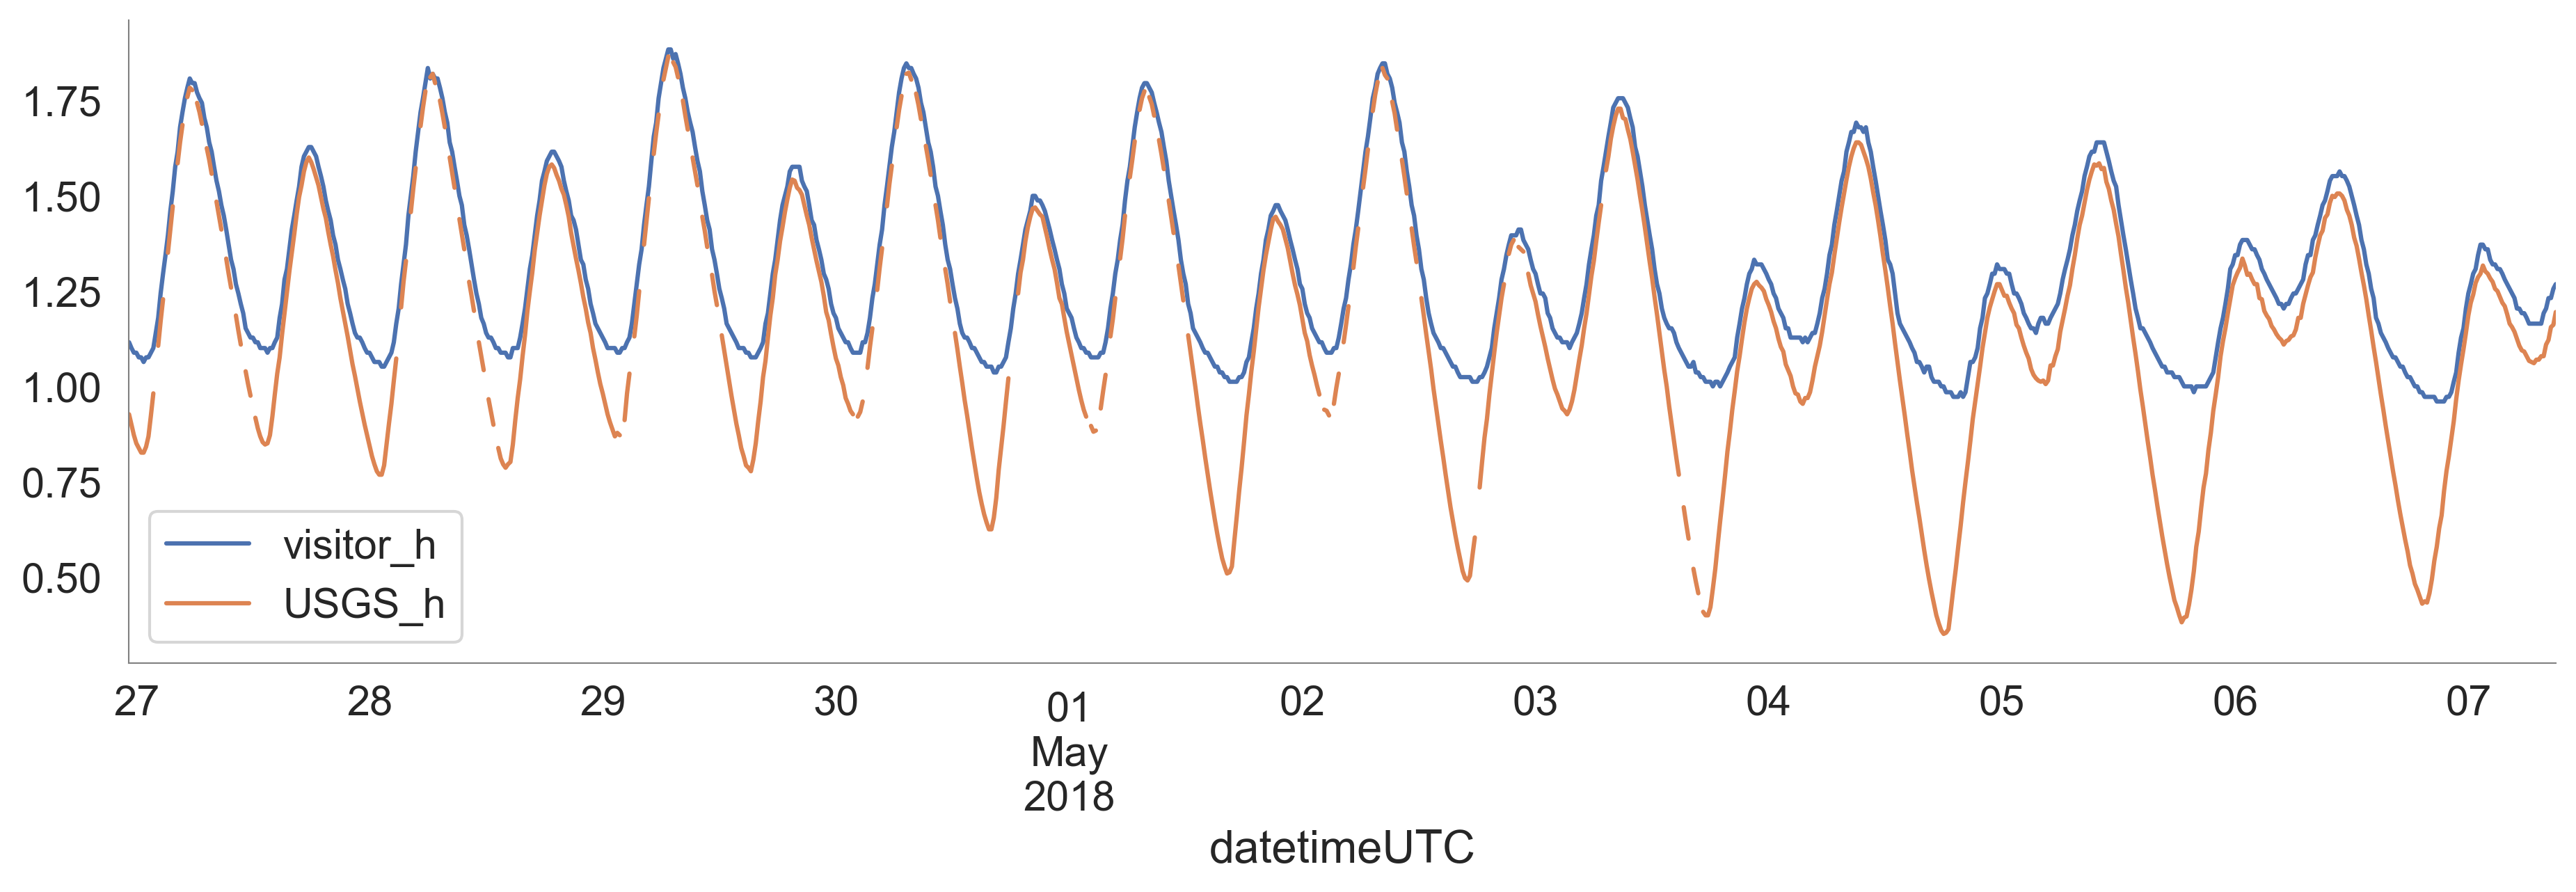

In [20]:
start_ind = np.where(hourly.USGS_h > 0)[0][0]

fig, ax = plt.subplots(1, figsize = (15, 4))
hourly[['visitor_h', 'USGS_h']][start_ind:start_ind + 1000].plot(ax = ax)

## Read inlet data and merge with hourly data

In [24]:

Inlet = pd.read_csv(data_path / 'closures/Russian_InletState_Speiser.csv')
Inlet = Inlet.sort_values("Date")
Inlet = Inlet.set_index(pd.to_datetime(Inlet.Date))
Inlet.loc[Inlet.query("State == '-'").index, 'State'] = np.nan
Inlet.loc[Inlet.query("State == '0'").index, 'State'] = 0
Inlet.loc[Inlet.query("State == '1'").index, 'State'] = 1

Inlet_ESA = pd.read_excel(data_path / 'closures/ESA RR closure record - through 2022.xlsx', header = 2)
Inlet_ESA.columns = ['Date', 'drop', 'State']

Inlet_ESA = Inlet_ESA.set_index(pd.to_datetime(Inlet_ESA.Date))
Inlet_ESA = Inlet_ESA.sort_index()
Inlet_ESA = Inlet_ESA[['State']]

Inlet_ESA = Inlet_ESA.join(Inlet[['State']].rename({"State" : 'State_WS'}, axis = 1), how='outer')
Inlet_ESA.index = Inlet_ESA.index.tz_localize("UTC")


### Correct mislabeled closures

In [26]:

# 10-4, 2015
# Inlet_ESA.date
start = pd.to_datetime('2021-10-22').tz_localize("UCT")
end = pd.to_datetime('2021-11-26').tz_localize("UCT")
Inlet_ESA.loc[start:end, 'State'] = 0
# Jan 25-30, 2015
# Inlet_ESA.date
start = pd.to_datetime('2015-01-25').tz_localize("UCT")
end = pd.to_datetime('2015-01-30').tz_localize("UCT")
Inlet_ESA.loc[start:end, 'State'] = 0
# 10-4, 2015
# Inlet_ESA.date
start = pd.to_datetime('2015-10-4').tz_localize("UCT")
end = pd.to_datetime('2015-10-4').tz_localize("UCT")
Inlet_ESA.loc[start:end, 'State'] = 0

### Copy 2023 from Speiser to ESA

In [27]:

# Copy 2023 from Speiser to ESA
copy_start = np.where(~Inlet_ESA['State'].isna() )[0][-1] + 1
copy_end = np.where(~Inlet_ESA['State_WS'].isna() )[0][-1] + 1

rows_to_update = Inlet_ESA.iloc[copy_start:copy_end].index
Inlet_ESA.loc[rows_to_update,'State'] = Inlet_ESA.loc[rows_to_update, 'State_WS']

### Merge inlet and hourly data on date

In [28]:
# Merge inlet and hourly data on date
Inlet_ESA['date'] = Inlet_ESA.index.date
hourly['date'] = hourly.index.date
merged = hourly[hourly.date <= Inlet_ESA.date.max()].merge(Inlet_ESA)
merged.index = hourly[hourly.date <= Inlet_ESA.date.max()].index

## NOAA data

In [29]:
import noaa_coops

In [30]:

fetch_data = 1
if fetch_data == 1:
    from noaa_coops import Station
    seattle = Station(id="9415020")
    df_water_levels = seattle.get_data(
        begin_date="20110101",
        end_date="20231026",
        product="water_level",
        datum="NAVD",
        units="metric",
        time_zone="gmt")

    df_water_levels.to_pickle(data_path / 'noaa_coops_9415020.pkl')
else:
    df_water_levels = pd.read_pickle(data_path /  'noaa_coops_9415020.pkl')
df_water_levels.index = df_water_levels.index.round('15min').tz_localize('GMT').tz_convert('UCT')


In [32]:
# fetch pt arena data
if fetch_data == 1:
    from noaa_coops import Station
    pt_arena = Station(id="9416841")
    df_pt_arena = pt_arena.get_data(
        begin_date="20110101",
        end_date="20231026",
        product="water_level",
        datum="NAVD",
        units="metric",
        time_zone="gmt")


    df_pt_arena.to_pickle(data_path / 'noaa_coops_9416841.pkl')
else:
    df_pt_arena = pd.read_pickle(data_path / 'noaa_coops_9416841.pkl')
df_pt_arena.index = df_pt_arena.index.round('15min').tz_localize('GMT').tz_convert('UCT')


## Merge hourly and ocean data

In [33]:
hourly = hourly.rename({"State" : 'closed'}, axis = 1)
Inlet_ESA['date'] = Inlet_ESA.index.date
hourly['date'] = hourly.index.date

merged = hourly[hourly.date <= Inlet_ESA.date.max()].merge(Inlet_ESA)
merged.index = hourly[hourly.date <= Inlet_ESA.date.max()].index
start = merged.query("visitor_h > 0").index[0]
end = merged.query("visitor_h > 0").index[-1]
merged = merged.join(df_water_levels[['v']], how = 'outer').loc[start:end]
merged = merged.groupby(merged.index).first()

In [34]:
result = sequence_lengths(merged.USGS_h.isna())

merged['USGS_gap'] = result
merged['USGS_filled'] = merged['USGS_h'].interpolate(method='polynomial', order=1)
merged.loc[merged.query('USGS_gap > 24').index, 'USGS_filled'] = np.nan

result = sequence_lengths(merged.visitor_h.isna())
merged['visitor_gap'] = result
merged['visitor_filled'] = merged['visitor_h'].interpolate(method='polynomial', order=1)
merged.loc[merged.query('visitor_gap > 24').index, 'visitor_filled'] = np.nan

merged['USGS-visitor'] = merged['USGS_h'] - merged['visitor_h']

In [35]:
# add closure lengths to merged
result = sequence_lengths(merged.State)
merged['closure'] = result

<Axes: >

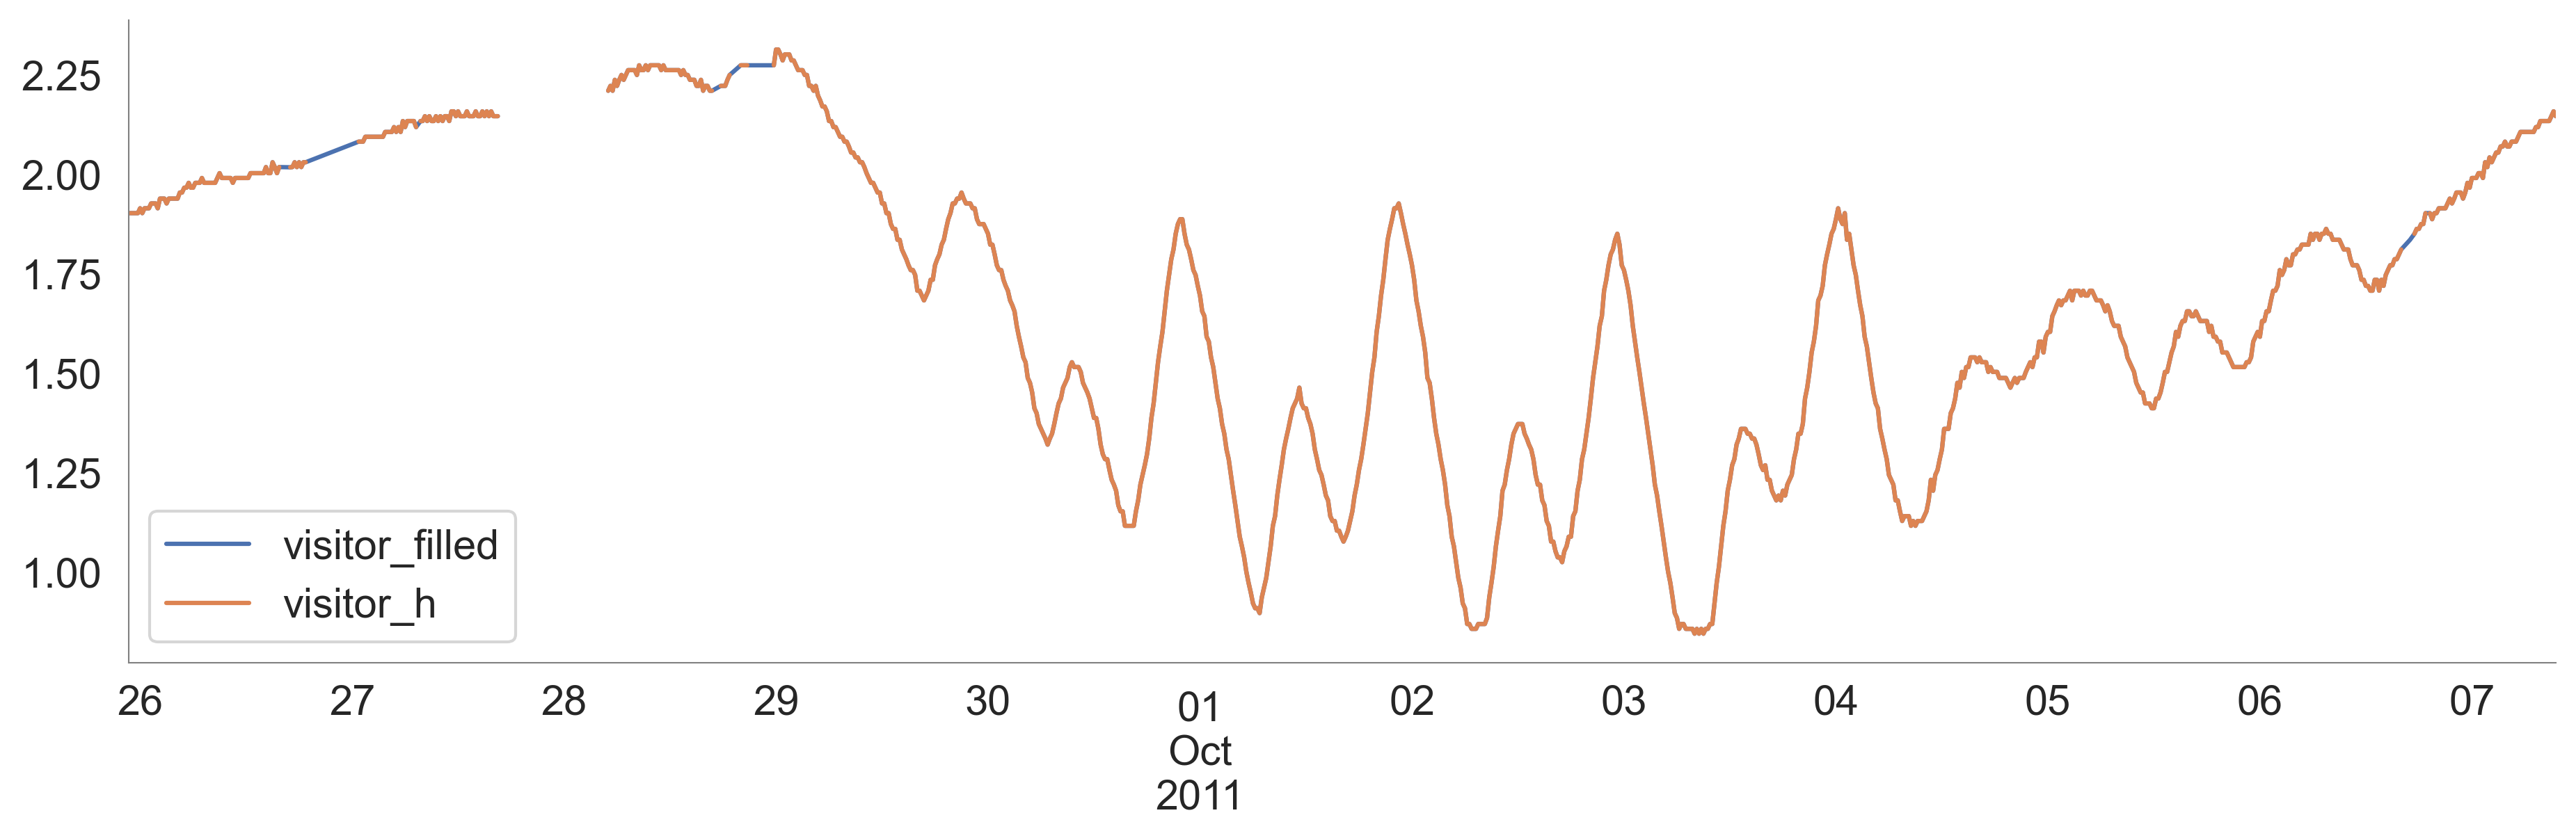

In [36]:
fig, ax = plt.subplots(1, figsize = (15, 4))
start_ind = np.where((merged['visitor_gap'] > 1) & (merged['visitor_gap'] < 40) )[0][100]

merged[[ 'visitor_filled','visitor_h',]][start_ind - 100:start_ind + 1000].plot(ax = ax)

In [37]:
merged[[ 'visitor_filled','visitor_h',]].isna().sum()

visitor_filled    37096
visitor_h         42601
dtype: int64

<Axes: >

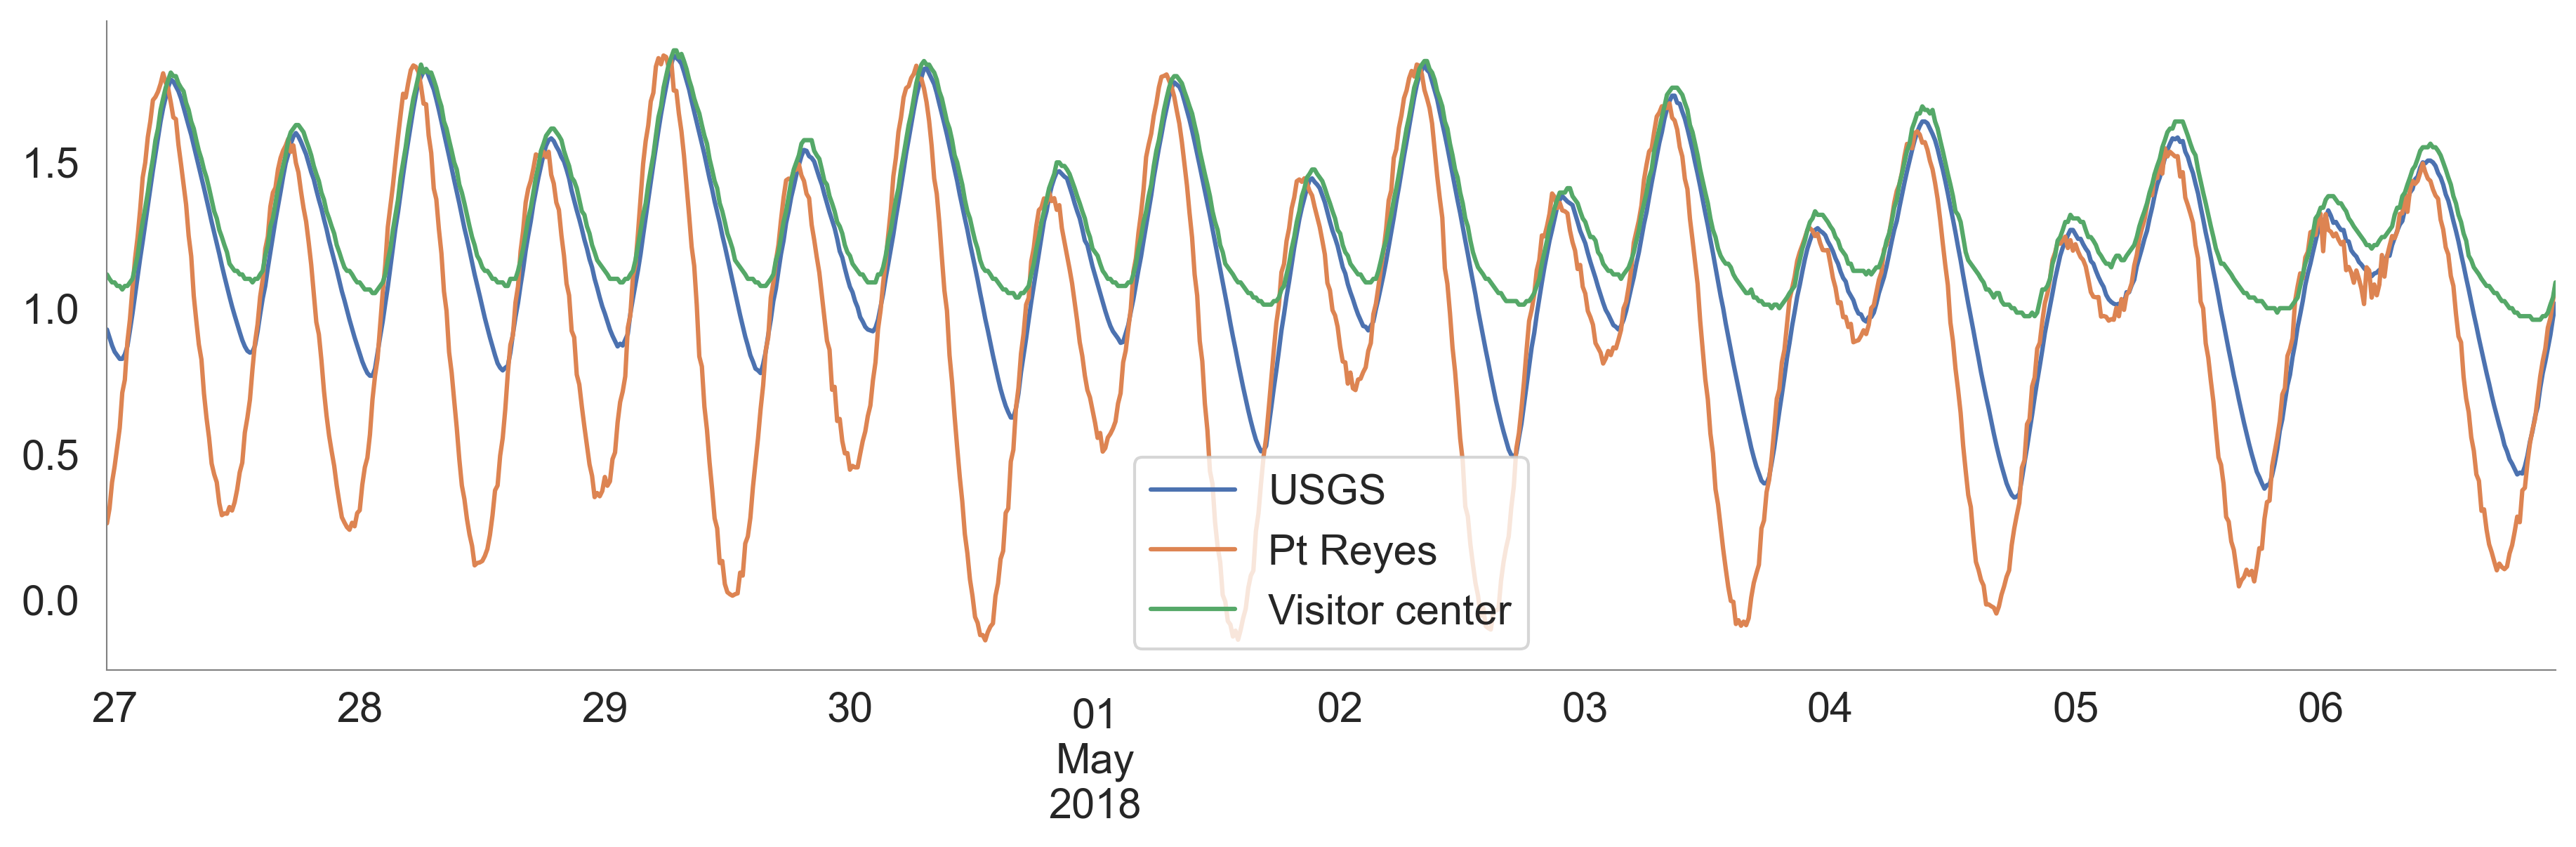

In [38]:
start_ind = np.where(merged.USGS_h >0)[0][0]
days = 10
plt.figure(figsize = (15, 4))

merged[['USGS_filled',  'v', 'visitor_filled']].rename(
    {'v' : 'Pt Reyes', 'USGS_filled' : 'USGS',
     'visitor_filled' : 'Visitor center'}, axis= 1
        ).iloc[start_ind:start_ind+days*24*4].plot(ax = plt.gca())
# maximum difference at ocean low tide


Text(0, 0.5, 'm (NAVD)')

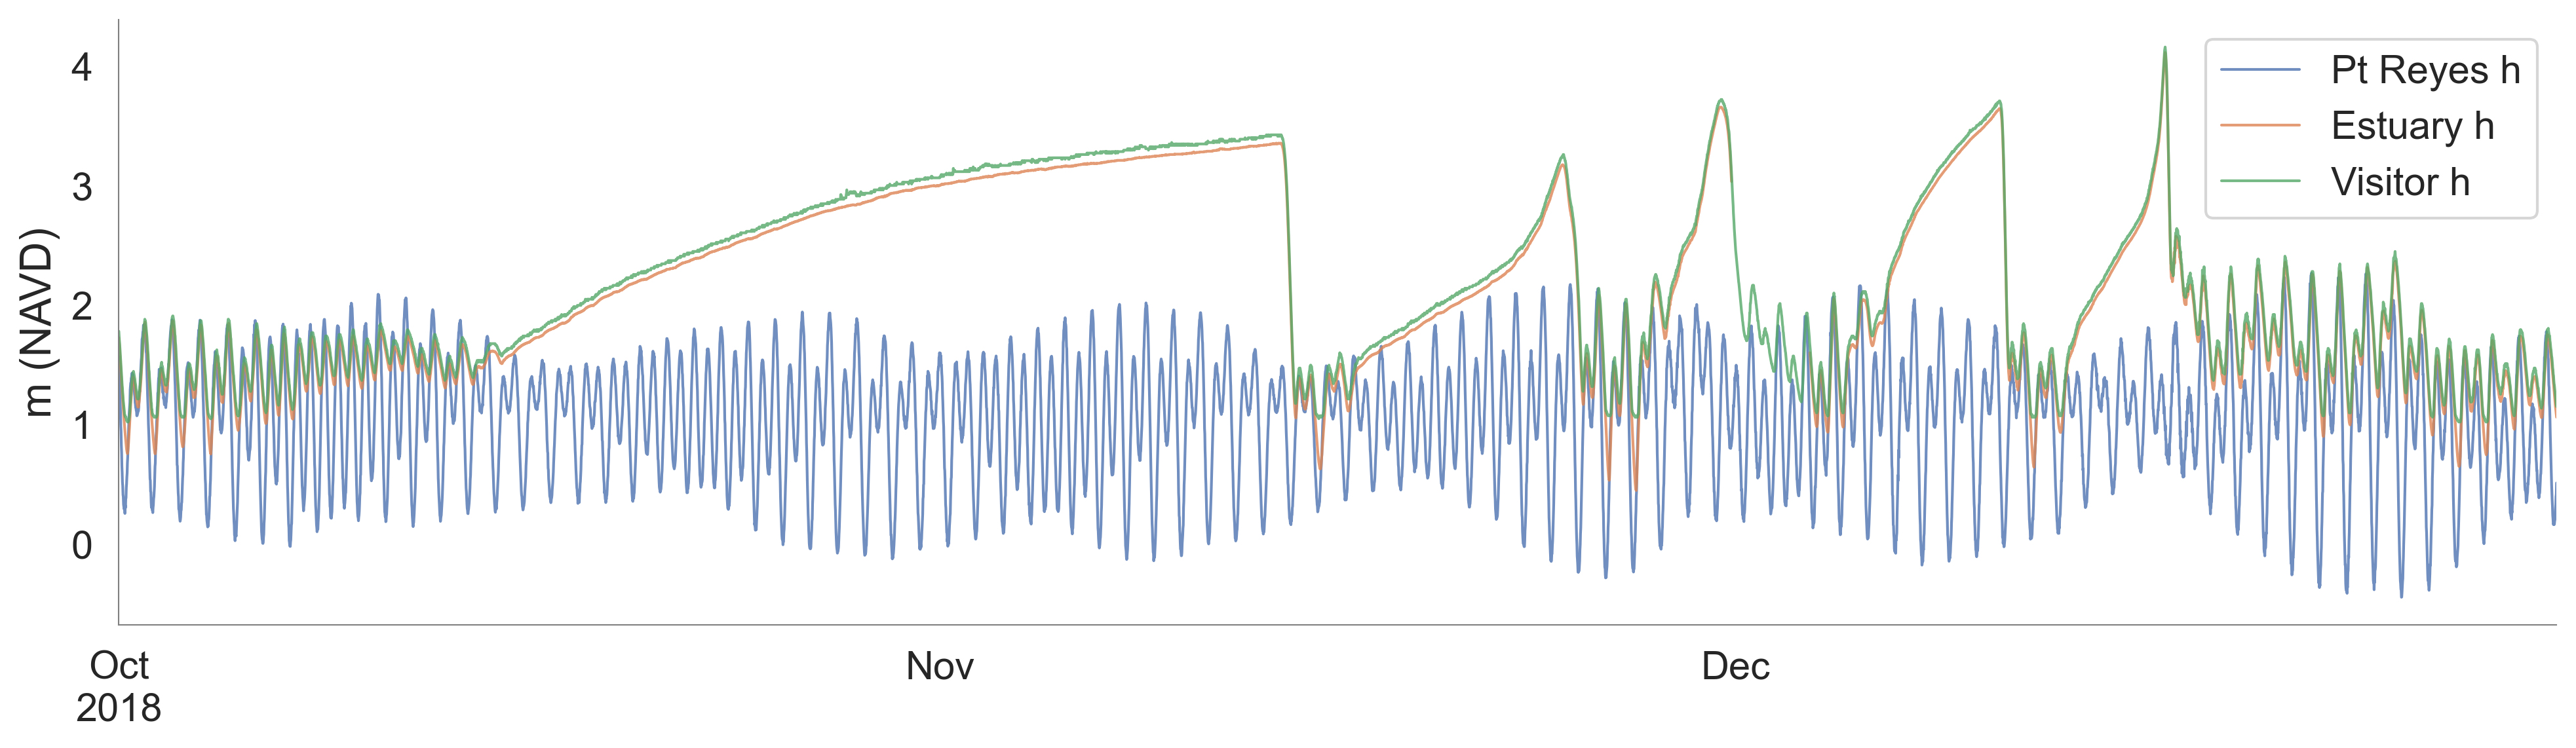

In [39]:
plt.figure(figsize = (16, 4))
year = 2018
inds = (merged.date > pd.to_datetime('{0}-9-30'.format(year)).date()) & \
    (merged.date < pd.to_datetime('{0}-1-1'.format(year + 1)).date())

merged[inds][[  'v', 'USGS_filled', 'visitor_filled']].rename({'v' : r'Pt Reyes h', 
                                                               'USGS_filled' : r'Estuary h',
                                                                'visitor_filled' : r'Visitor h'
                                                              }, axis= 1).plot(ax = plt.gca(), alpha = 0.8, lw = 1)
plt.ylabel("m (NAVD)")


In [ ]:
plt.figure(figsize = (16, 4))

merged[['USGS_filled', 'visitor_filled']].query(
    "visitor_filled > 2.1").diff(axis = 1)['visitor_filled'].hist(bins = np.arange(-.2, 0.2, 0.02));

In [ ]:
plt.figure(figsize = (16, 4))
year = 2020
inds = (merged.date > pd.to_datetime('{0}-10-1'.format(year)).date()) & \
    (merged.date < pd.to_datetime('{0}-2-4'.format(year+1)).date())

merged[[  'v', 'USGS_filled']].rename(
    {'v' : 'Pt Reyes h', 'USGS_filled' : 'Estuary h', 'visitor_filled': 'visitor h'}, axis= 1
        )[inds].plot(ax = plt.gca(), alpha = 0.8, lw = 1)
plt.ylabel("m (NAVD)")
# plt.title("{0} ".format(year))
plt.yticks([0, 1,2,3]);
ax = plt.gca()
ax.text(-0.05, 1.1, 'C', transform=ax.transAxes, ha="left", va="top",
        fontsize = 18, style = 'italic');

In [ ]:
plt.figure(figsize = (15, 4))
year = 2020
inds = (merged.date > pd.to_datetime('{0}-9-19'.format(year)).date()) & \
    (merged.date < pd.to_datetime('{0}-11-25'.format(year)).date())

merged[[  'v', 'USGS_filled']].rename(
    {'v' : 'Pt Reyes h', 'USGS_filled' : 'Estuary h', 'visitor_filled': 'visitor h'}, axis= 1
        )[inds].plot(ax = plt.gca(), alpha = 0.8, lw = 1)
plt.ylabel("m (NAVD)")
# plt.title("{0} ".format(year))


## Read hypso

In [ ]:
hypso = pd.read_excel(root + '/data/RR_stage_storage.xlsx',header=3)

hypso.columns = ['h_m', 'vol_m3', 'A_m2']
hypso['h_m'] = hypso['h_m'] + 2.73*0.3048

hypso.head()

In [ ]:
hypso['vol_m3'].max()/ hypso['h_m'].max()
# 2235803.62 m2, 223 km2

### Hypso plots

In [ ]:
plt.figure(figsize = (12, 3))
ax = plt.gca()
ax.plot(hypso.h_m, hypso.vol_m3, '.', ms = 5)
ax.set_ylabel("Vol (m^3)")
ax.set_xlabel("Elev (m) NAVD")
ax.set_yscale("log")
plt.axvline(merged.USGS_h.min(),  c = 'C1', label = "USGS min")
plt.axvline(merged.USGS_h.max(), c = 'C2', label = "USGS max")
plt.axvline(np.percentile(merged.USGS_h.dropna(), 99.5), c = 'C3', label = "USGS 99.5th percentile")
ax.legend()
ax.set_xlim(-10, 8)

In [ ]:
# plt.figure(figsize = (12, 3))
# plt.plot(hypso.h_m, hypso.A_m2, '.', ms = 5)
# plt.ylabel("Area (m2)")
# plt.xlabel("Elev (m) NAVD")


## Add hypso data to merged dataframe

In [ ]:
def add_vol(h_name, subset, name = "vol_m3"):
    """
    add hypsometry...
    """
    for i, ind in enumerate(subset[h_name].dropna().index):
        diff = (subset.loc[ind][h_name] - hypso.h_m).dropna().abs()
        subset.at[ind, name] = hypso.iloc[diff.idxmin()].vol_m3
    return subset



### Gauge data out of bounds

In [ ]:
plt.figure(figsize = (15, 4))

inds = (merged.date > pd.to_datetime('2023-1-1').date()) &  (merged.date < pd.to_datetime('2023-1-20').date())

merged[['USGS_filled', 'visitor_filled',  'v', 'State']].rename(
    {'v' : 'Pt Reyes', 'USGS_filled' : 'USGS $h$', 'visitor_filled':  'visitor $h$'}, axis= 1
        )[inds].plot(ax = plt.gca())
plt.ylabel("m (NAVD)")
plt.axhline(3.632104, ls = ':', label = 'hypso max')
plt.axvline(pd.to_datetime('2023-1-5').date(), lw = 1, c = 'k')


In [ ]:
plt.figure(figsize = (15, 4))
inds = (merged.date > pd.to_datetime('2021-11-25').date()) &  (merged.date < pd.to_datetime('2021-11-28').date())

merged[['visitor_filled',  'v', 'State']].rename(
    {'v' : 'Pt Reyes', 'visitor_filled' : 'visitor $h$', 'USGS_filled' : 'USGS $h$',}, axis= 1
        )[inds].plot(ax = plt.gca())
plt.ylabel("m (NAVD)")
plt.axhline(3.632104, ls = ':', label = 'hypso max')


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 4))
inds = (merged.date > pd.to_datetime('2012-1-1').date()) & (merged.date < pd.to_datetime('2012-1-30').date())

# Rename columns for plotting
df_plot = merged[['visitor_filled', 'v', 'State']].rename(
    {'v': 'Pt Reyes', 'visitor_filled': 'visitor $h$', 'USGS_filled': 'USGS $h$'}, axis=1
)[inds]

# Plot each column with markers only
for col in df_plot.columns:
    plt.plot(df_plot.index, df_plot[col], marker='.', linestyle='', label=col)

plt.ylabel("m (NAVD)")
plt.axhline(3.632104, ls=':', color='gray', label='hypso max')
plt.legend()

## Identify closures

In [ ]:
plt.rcParams['figure.figsize'] = (12.0, 6.0)
for mod in ['plot_config', 'timeseries_functions']:
    if mod in sys.modules:
        del sys.modules[mod]

import plot_config
from timeseries_functions import *
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

In [ ]:
merged = add_power_visitor(merged, 24, label = 'visitor_24_hr' )
merged = add_power_USGS(merged, 24, label = 'USGS_24_hr' )

merged.to_pickle("merged.pkl")


In [ ]:
# merged = pd.read_pickle("merged.pkl")